In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

In [3]:
data = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Fraud_Data.csv')

In [4]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip_addresses = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/IpAddress_to_Country.csv')

In [6]:
ip_addresses.head(1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia


In [7]:
data_country = [None] * data.shape[0]

In [8]:
for i in range(data.shape[0]):
       tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                          (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])
                         ]['country'].values
       if (len(tmp) == 1):  
               data_country[i] = tmp

In [9]:
print(data_country[0:3])

[array(['Japan'], dtype=object), array(['United States'], dtype=object), array(['United States'], dtype=object)]


In [10]:
data['country'] = data_country

In [14]:
data.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan


In [12]:
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [13]:
#Pandas str.get() method is used to get element at the passed position
data['country'] = data['country'].str.get(0)

In [15]:
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
from numpy.core.umath_tests import inner1d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

In [18]:
#make them dates
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])
#and take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

In [19]:
#DataFrame.transform(self, func, axis=0, *args, **kwargs) → 'DataFrame'[source]
#Call func on self producing a DataFrame with transformed values.
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')

In [20]:
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

In [21]:
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)

In [22]:
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)

In [23]:
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)

In [24]:
#make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True) 
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)

In [25]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9563033298908085 
 OOB Confusion Matrix 
        0     1
0  90351    94
1   4264  5024


In [27]:
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9556238930302263 
 Test Set Confusion Matrix 
        0     1
0  46481    35
1   2245  2618


In [28]:
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


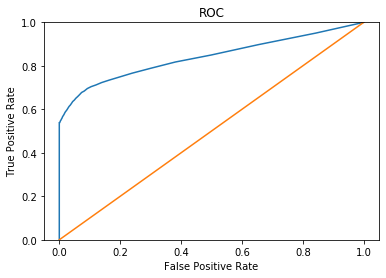

In [29]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [30]:
#For consistency with R, we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                               'class0_error':pandas.Series(fpr),
                               'class1_error': 1 - pandas.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
58    0.14       0.07333      0.322435       0.604236
